# Predicting a Digit From an Image Using Other Methods :

- Binary Classifier Case : 0 is class 1, All Other are class -1
    - [SGD Classifier](#SGDC)
    - [Logistic Regression](#LR)
    - [Logistic Regression with Cross Validation](#LRCV)
    - [Ridge Classifier](#RC)
- Multi Class Classifier Case
    - [Multi Class SGD Classifier ( Log Loss )](#MCSGDC)
    - [Multi Class Logistic Regression ( Solver )](#MCLR)
- [Appendix](#APPENDIX)

In [2]:
import numpy as np
from pprint import pprint

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import log_loss, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

from scipy.stats import loguniform

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', figsize=(8, 6))

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [3]:
from sklearn.datasets import fetch_openml
X_pd, y_pd = fetch_openml('mnist_784', version=1, return_X_y=True)

X = X_pd.to_numpy()
y = y_pd.to_numpy()

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [4]:
target_names = np.unique(y)
print("Number of samples : ", X.shape[0], "Type : ", X.dtype)
print("Number of features : ", X.shape[1])
print("Minimum : ", np.min(X), "Maximum : ", np.max(X))
print("Number of classes : ", len(target_names), "Type : ", y.dtype)
print("Labels : ", target_names)

print("\nMean of the features : ", np.mean(X))
print("Std.deviation :", np.std(X))
print("Minimum value : ", np.min(X))
print("Maximum value : ", np.max(X))

Number of samples :  70000 Type :  float64
Number of features :  784
Minimum :  0.0 Maximum :  255.0
Number of classes :  10 Type :  object
Labels :  ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']

Mean of the features :  33.385964741253645
Std.deviation : 78.65437362689433
Minimum value :  0.0
Maximum value :  255.0


In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

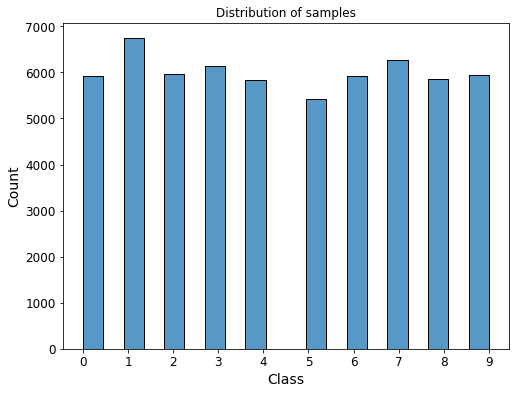

In [6]:
plt.figure()
sns.histplot(data=np.int8(y_train), binwidth=0.45, bins=11)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Class')
plt.title('Distribution of samples')
plt.show()

## Binary Classifiers

In [7]:
# Initialize new variable names with all 0
y_train_0 = np.zeros(y_train.shape[0])
y_test_0 = np.zeros(y_test.shape[0])

# Find indices of digit 0 image
indx_0 = np.where(y_train == '0')
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

print(y_train)
print(y_train_0)

['5' '0' '4' ... '5' '6' '8']
[0. 1. 0. ... 0. 0. 0.]


### Dummy (Baseline) Classifier

In [8]:
num_pos = len(np.where(y_train_0 == 1)[0])
num_neg = len(np.where(y_train_0 == 0)[0])

base_clf = DummyClassifier(strategy='most_frequent')
base_clf.fit(X_train, y_train_0)
print("Training Accuracy : ", round(base_clf.score(X_train, y_train_0), 4))
print("Testing Accuracy : ", base_clf.score(X_test, y_test_0))

Training Accuracy :  0.9013
Testing Accuracy :  0.902


Reason is obvious. The model would've predicted 54077 samples correctly just by output 0 for all nput samples, Therefore, the accuracy will be 54077/60000 = 90.12%

### <a id="SGDC"></a> SGD Classifier ( Log Loss ) - `SGDClassifier()`

In [10]:
bin_sgd_clf = SGDClassifier(loss="log", penalty='l2', max_iter=1, warm_start=True, eta0=0.01, alpha=0, learning_rate='constant', random_state=1729)

loss = []
iterations = 100
for i in range(iterations):
    bin_sgd_clf.fit(X_train, y_train_0)
    y_pred = bin_sgd_clf.predict_proba(X_train)
    loss.append(log_loss(y_train_0, y_pred))

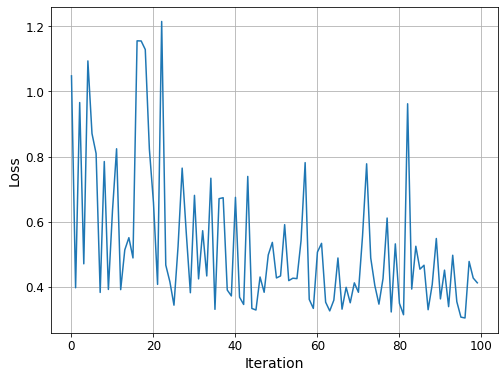

In [12]:
plt.figure()
plt.plot(np.arange(iterations), loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

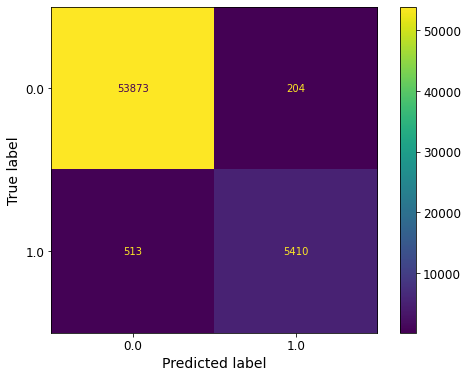

In [13]:
y_hat_train_0 = bin_sgd_clf.predict(X_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='0.5g')

In [14]:
print(classification_report(y_train_0, y_hat_train_0))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     54077
         1.0       0.96      0.91      0.94      5923

    accuracy                           0.99     60000
   macro avg       0.98      0.95      0.97     60000
weighted avg       0.99      0.99      0.99     60000



Now, let's see how much generalization can be achieved by **cross-validation**

In [15]:
estimator = SGDClassifier(loss='log', penalty='l2', max_iter=100, warm_start=False, eta0=0.01, alpha=0, learning_rate='constant', random_state=1729)

cv_bin_clf = cross_validate(estimator, X_train, y_train_0, cv=5, scoring=['precision', 'recall', 'f1'], return_train_score=True, return_estimator=True)

pprint(cv_bin_clf)

{'estimator': [SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729)],
 'fit_time': array([1.40572643, 1.54716682, 1.31940651, 1.391855  , 1.77094102]),
 'score_time': array([0.02586031, 0.02985525, 0.02586865, 0.02885342, 0.02950382]),
 'test_f1': array([0.94338052, 0.92622951, 0.94646681, 0.93399751, 0.94008439]),
 'test_precision': array([0.93021346, 0.89968153, 0.96086957, 0.91911765, 0.9

In [16]:
weights = bin_sgd_clf.coef_
bias = bin_sgd_clf.intercept_
weights.shape, bias

((1, 784), array([-90.52439913]))

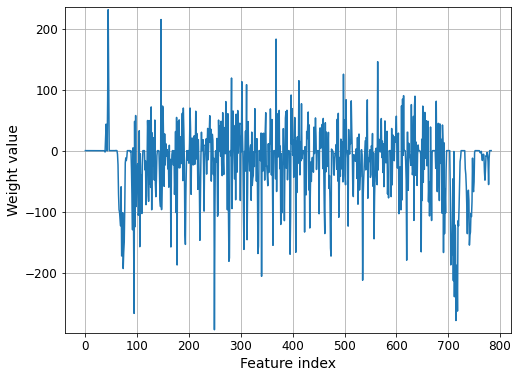

In [17]:
plt.figure()
plt.plot(np.arange(0, 784), weights[0, :])
plt.xlabel('Feature index')
plt.ylabel('Weight value')
plt.ylim(np.min(weights) - 5, np.max(weights) + 5)
plt.grid()

**Training with regularization**

In [20]:
bin_sgd_clf_l2 = SGDClassifier(loss='log', penalty='l2', max_iter=1, warm_start=True, eta0=0.01, alpha=0.001, learning_rate='constant', random_state=1729)
loss = []
iterations = 100
for i in range(iterations):
    bin_sgd_clf_l2.fit(X_train, y_train_0)
    y_pred = bin_sgd_clf_l2.predict_proba(X_train)
    loss.append(log_loss(y_train_0, y_pred))

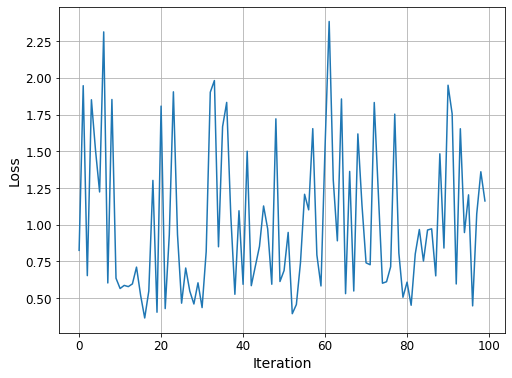

In [21]:
plt.figure()
plt.plot(np.arange(iterations), loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

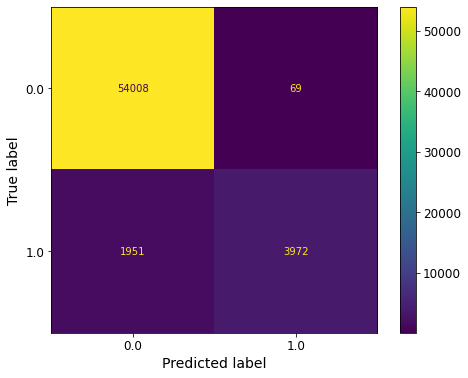

In [22]:
y_hat_train_0 = bin_sgd_clf_l2.predict(X_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='0.5g')

In [23]:
print(classification_report(y_train_0, y_hat_train_0))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     54077
         1.0       0.98      0.67      0.80      5923

    accuracy                           0.97     60000
   macro avg       0.97      0.83      0.89     60000
weighted avg       0.97      0.97      0.96     60000



In [24]:
weights = bin_sgd_clf_l2.coef_
bias = bin_sgd_clf_l2.intercept_
weights.shape, bias

((1, 784), array([-142.47486255]))

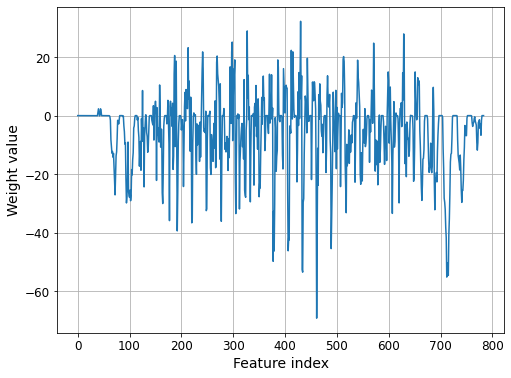

In [25]:
plt.figure()
plt.plot(np.arange(0, 784), weights[0, :])
plt.xlabel('Feature index')
plt.ylabel('Weight value')
plt.ylim(np.min(weights) - 5, np.max(weights) + 5)
plt.grid()

**Hyper-parameter tuning using Randomized Search CV**

In [26]:
from scipy.sparse.construct import random

lr_grid = loguniform(1e-2, 1e-1)
print(lr_grid.rvs(3, random_state=42))

[0.02368864 0.0892718  0.05395031]


In [27]:
estimator = SGDClassifier(loss='log', penalty='l2', max_iter=1, warm_start=True, eta0=0.01, alpha=0, learning_rate='constant', random_state=1729)

scores = RandomizedSearchCV(estimator, param_distributions={'eta0': lr_grid}, cv=5, scoring=['precision', 'recall', 'f1'], n_iter=5, refit='f1')

scores.fit(X_train, y_train_0)

RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(alpha=0, eta0=0.01,
                                           learning_rate='constant', loss='log',
                                           max_iter=1, random_state=1729,
                                           warm_start=True),
                   n_iter=5,
                   param_distributions={'eta0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000026D95402100>},
                   refit='f1', scoring=['precision', 'recall', 'f1'])

In [28]:
scores.cv_results_

{'mean_fit_time': array([0.27113218, 0.29042344, 0.29878454, 0.28586783, 0.29633441]),
 'std_fit_time': array([0.02485351, 0.02127051, 0.03113305, 0.01763733, 0.02071522]),
 'mean_score_time': array([0.03148608, 0.03078971, 0.03305068, 0.03200998, 0.03119497]),
 'std_score_time': array([0.00466238, 0.00499963, 0.00561458, 0.00560607, 0.00348516]),
 'param_eta0': masked_array(data=[0.02368863950364078, 0.08927180304353625,
                    0.05395030966670228, 0.039687933304443715,
                    0.01432249371823025],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'eta0': 0.02368863950364078},
  {'eta0': 0.08927180304353625},
  {'eta0': 0.05395030966670228},
  {'eta0': 0.039687933304443715},
  {'eta0': 0.01432249371823025}],
 'split0_test_precision': array([0.77335984, 0.77335984, 0.77335984, 0.77335984, 0.77335984]),
 'split1_test_precision': array([0.88828125, 0.9064    , 0.9064    , 0.9064    , 0.892717

In [29]:
scores.best_estimator_

SGDClassifier(alpha=0, eta0=0.02368863950364078, learning_rate='constant',
              loss='log', max_iter=1, random_state=1729, warm_start=True)

In [30]:
y_hat_train_best_0 = scores.best_estimator_.predict(X_train)

In [31]:
print(classification_report(y_train_0, y_hat_train_best_0))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     54077
         1.0       0.98      0.82      0.89      5923

    accuracy                           0.98     60000
   macro avg       0.98      0.91      0.94     60000
weighted avg       0.98      0.98      0.98     60000



### <a id="LR"></a>Logistic Regression

In [32]:
# C = np.infty means 0 regularization
pipe_logit = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=1729, solver='lbfgs', C=np.infty)) 
pipe_logit.fit(X_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])

**Hyper-parameter search using Grid Search CV**

In [34]:
from sklearn.pipeline import Pipeline

grid_Cs = [0, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]

scaler = MinMaxScaler()

logreg = LogisticRegression(C=1.0, random_state=1729) # initialized C with some value, and use grid_Cs for GridSearchCV

pipe = Pipeline(steps=[('scaler', scaler), ('logistic', logreg)])
pipe_logit_cv = GridSearchCV(pipe, param_grid={'logistic__C': grid_Cs}, scoring='f1')
pipe_logit_cv.fit(X_train, y_train_0)

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('logistic',
                                        LogisticRegression(random_state=1729))]),
             param_grid={'logistic__C': [0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                         100.0]},
             scoring='f1')

In [35]:
pipe_logit_cv.best_params_

{'logistic__C': 0.1}

In [36]:
pipe_logit_cv.best_score_

0.9579654953103655

In [37]:
pipe_logit_cv.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logistic', LogisticRegression(C=0.1, random_state=1729))])

### <a id="LRCV"></a>Logistic Regression with Cross Validation 
Using `LogisticRegressionCV()` instead of `GridSearchCV`

In [40]:
estimator = LogisticRegressionCV(cv=5, scoring='f1', random_state=1729)
logit_cv = make_pipeline(MinMaxScaler(), estimator)
logit_cv.fit(X_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregressioncv',
                 LogisticRegressionCV(cv=5, random_state=1729, scoring='f1'))])

In [41]:
lr_y_hat_0 = pipe_logit.predict(X_test)
lr_gs_y_hat_0 = pipe_logit_cv.best_estimator_.predict(X_test)
lr_cv_y_hat_0 = logit_cv.predict(X_test)

In [44]:
print(classification_report(lr_y_hat_0, lr_cv_y_hat_0))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9010
         1.0       0.99      0.99      0.99       990

    accuracy                           1.00     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       1.00      1.00      1.00     10000



In [48]:
precision_lr = precision_score(y_test_0, lr_y_hat_0)
recall_lr = recall_score(y_test_0, lr_y_hat_0)

precision_lr_gs = precision_score(y_test_0, lr_gs_y_hat_0)
recall_lr_gs = recall_score(y_test_0, lr_gs_y_hat_0)

precision_lr_cv = precision_score(y_test_0, lr_cv_y_hat_0)
recall_lr_cv = recall_score(y_test_0, lr_cv_y_hat_0)

print("LogReg: \n", "Precision = ", precision_lr, "  Recall = ", recall_lr)
print("GridSearch: \n", "Precision = ", precision_lr_gs, "  Recall = ", recall_lr_gs)
print("LogRegCV: \n", "Precision = ", precision_lr_cv, "  Recall = ", recall_lr_cv)

LogReg: 
 Precision =  0.9515151515151515   Recall =  0.9612244897959183
GridSearch: 
 Precision =  0.9564336372847011   Recall =  0.963265306122449
LogRegCV: 
 Precision =  0.9546370967741935   Recall =  0.9663265306122449


**RESULT :** LogisticRegression classifier obtained through GridSearchCV has the highest precision

In [49]:
y_scores_lr = pipe_logit.decision_function(X_test)
precision_lr, recalls_lr, threshold_lr = precision_recall_curve(y_test_0, y_scores_lr)

y_scores_lr_gs = pipe_logit_cv.decision_function(X_test)
precision_lr_gs, recalls_lr_gs, threshold_lr_gs = precision_recall_curve(y_test_0, y_scores_lr_gs)

y_scores_lr_cv = logit_cv.decision_function(X_test)
precision_lr_cv, recalls_lr_cv, threshold_lr_cv = precision_recall_curve(y_test_0, y_scores_lr_cv)

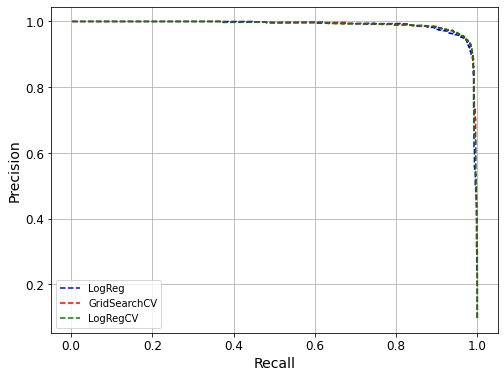

In [50]:
plt.figure()
plt.plot(recalls_lr[:-1], precision_lr[:-1], 'b--', label='LogReg')
plt.plot(recalls_lr_gs[:-1], precision_lr_gs[:-1], 'r--', label='GridSearchCV')
plt.plot(recalls_lr_cv[:-1], precision_lr_cv[:-1], 'g--', label='LogRegCV')

plt.ylabel('Precision')
plt.xlabel('Recall')
plt.grid(True)
plt.legend(loc='lower left')

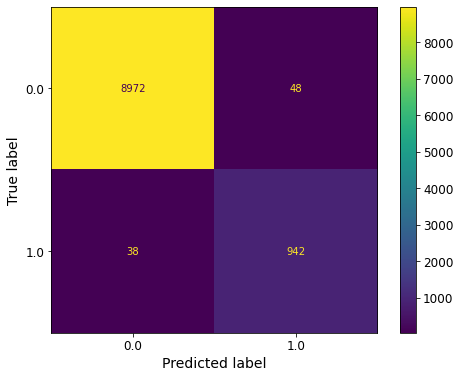

In [51]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_y_hat_0, values_format='0.5g') # From logistic regression

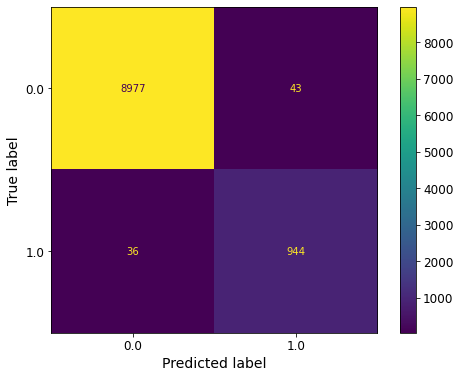

In [52]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_gs_y_hat_0, values_format='0.5g') # From GridSearchCV

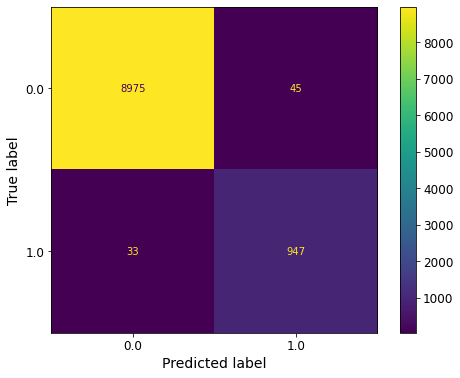

In [53]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_cv_y_hat_0, values_format='0.5g') # LogisticRegressionCV

## <a id="RC"></a>Ridge Classifier

- The Ridge Classifier, based on Ridge regression method, **converts the label data into [-1, 1] and solves the problem with regression method.** The highest value in prediction is accepted as a target class and for multiclass data muilti-output regression is applied
- **The loss function of Ridge Classifier is not Cross Entropy ( like Logistic Regression ). Instead, it is MSE + L2 Regularization**

In [55]:
# Initialize new variable names with all 0
y_train_0 = -1 * np.ones(y_train.shape[0])
y_test_0 = -1 * np.ones(y_test.shape[0])

# Find indices of digit 0 image
indx_0 = np.where(y_train == '0')
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

print(y_train)
print(y_train_0)

['5' '0' '4' ... '5' '6' '8']
[-1.  1. -1. ... -1. -1. -1.]


In [56]:
estimator = RidgeClassifier(normalize=False, alpha=0) # No regularization
pipe_ridge = make_pipeline(MinMaxScaler(), estimator)
pipe_ridge.fit(X_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))])

In [57]:
y_hat_test_0 = pipe_ridge.predict(X_test)
print(classification_report(y_test_0, y_hat_test_0))

              precision    recall  f1-score   support

        -1.0       0.98      1.00      0.99      9020
         1.0       0.96      0.86      0.90       980

    accuracy                           0.98     10000
   macro avg       0.97      0.93      0.95     10000
weighted avg       0.98      0.98      0.98     10000



**Cross Validation**

In [58]:
cv_bin_ridge_clf = cross_validate(pipe_ridge, X_train, y_train_0, cv=5, scoring=['precision', 'recall', 'f1'], return_train_score=True, return_estimator=True)

pprint(cv_bin_ridge_clf)

{'estimator': [Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))])],
 'fit_time': array([4.57430267, 4.69403362, 4.55519128, 4.77518702, 5.14193082]),
 'score_time': array([0.08072948, 0.08328342, 0.07682562, 0.08738041, 0.08465433]),
 'test_f1': array([0.90414623, 0.90434012, 0.91135857, 0.90302491, 0.90795353]),
 'test_precision'

In [59]:
best_estimator_id = np.argmax(cv_bin_ridge_clf['train_f1'])
print(best_estimator_id)

3


In [60]:
best_estimator = cv_bin_ridge_clf['estimator'][best_estimator_id]

In [62]:
y_hat_test_0 = best_estimator.predict(X_test)
print(classification_report(y_test_0, y_hat_test_0))

              precision    recall  f1-score   support

        -1.0       0.99      0.99      0.99      9020
         1.0       0.95      0.88      0.91       980

    accuracy                           0.98     10000
   macro avg       0.97      0.94      0.95     10000
weighted avg       0.98      0.98      0.98     10000



### <a id="MCSGDC"></a>Multi Class SGD Classifier ( Log Loss )

In [63]:
estimator = SGDClassifier(loss='log', penalty='l2', max_iter=1, warm_start=True, eta0=0.01, alpha=0, learning_rate='constant', random_state=1729)
pipe_sgd_ovr = make_pipeline(MinMaxScaler(), estimator)

In [64]:
loss = []
iterations = 100
for i in range(iterations):
    pipe_sgd_ovr.fit(X_train, y_train)  # Train on all classes
    y_pred = pipe_sgd_ovr.predict_proba(X_train)
    loss.append(log_loss(y_train, y_pred))

Text(0, 0.5, 'Loss')

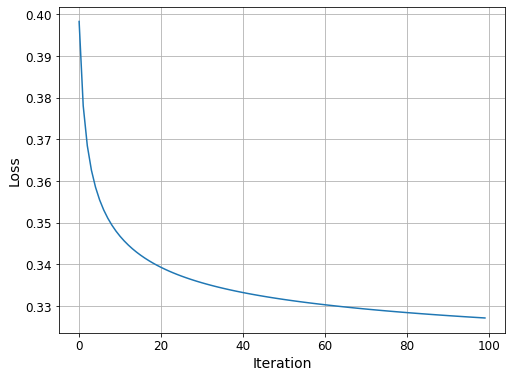

In [66]:
plt.figure()
plt.plot(np.arange(iterations), loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')

In [67]:
y_hat = pipe_sgd_ovr.predict(X_test)

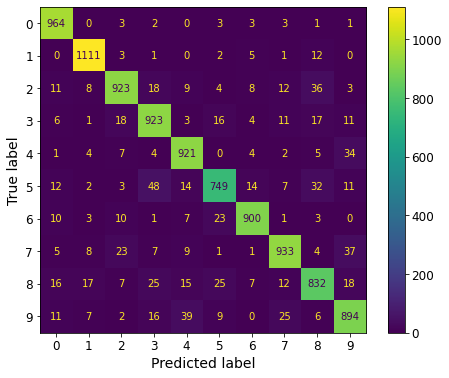

In [68]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_hat, values_format='0.5g')

In order to manually calculate the precision and recall, follow this procedure on the above ConfusionMatrix.
- True positive: diagonal position, cm(x, x).
- False positive: sum of column x (without main diagonal), sum(cm(:, x))-cm(x, x).
- False negative: sum of row x (without main diagonal), sum(cm(x, :), 2)-cm(x, x).

Note that the same report can be automatically obtained through the function classification_report


In [69]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.92      0.89      0.91      1032
           3       0.88      0.91      0.90      1010
           4       0.91      0.94      0.92       982
           5       0.90      0.84      0.87       892
           6       0.95      0.94      0.95       958
           7       0.93      0.91      0.92      1028
           8       0.88      0.85      0.87       974
           9       0.89      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.92      0.91     10000



### <a id="MCLR"></a>Multiclass Logistic Regression ( Solvers )

In [70]:
# C=np.infty indicates no regularization
pipe_logit_ovr = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=1729, solver='lbfgs', C=np.infty))  
pipe_logit_ovr.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])

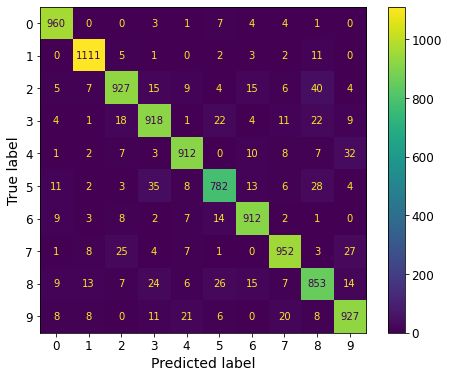

In [71]:
y_hat = pipe_logit_ovr.predict(X_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_hat, values_format='0.5g')

In [72]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.93      0.93       982
           5       0.91      0.88      0.89       892
           6       0.93      0.95      0.94       958
           7       0.94      0.93      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



## <a id="APPENDIX"></a>Appendix

### Logistic Regression

**Loss Function aka Binary Cross Entropy Loss**

$$
J(\textbf w) = - \sum\limits_{i=1}^{n} \left [ y^{(i)}log\left ( h(\textbf x^{(i)})  \right ) + (1-y^{(i)})log\left ( 1- h(\textbf x^{(i)})  \right ) \right ]
$$

*With L1 Regularization :*

$$
J(\textbf w) = - \sum\limits_{i=1}^{n} \left [ y^{(i)}log\left ( h(\textbf x^{(i)})  \right ) + (1-y^{(i)})log\left ( 1- h(\textbf x^{(i)})  \right ) \right ] + \frac {\lambda } {2} || \textbf w||
$$

*With L2 Regularization :*

$$
J(\textbf w) = - \sum\limits_{i=1}^{n} \left [ y^{(i)}log\left ( h(\textbf x^{(i)})  \right ) + (1-y^{(i)})log\left ( 1- h(\textbf x^{(i)})  \right ) \right ] + \frac {\lambda } {2} || \textbf w||^{2}
$$

where $h(\textbf x^{(i)})$ refers to the non-linear transformation of variable $\textbf x^{(i)}$. Here, it is the *sigmoid function* :

$$
sigmoid(\textbf x) = \frac {1} {1 + e^{-\textbf x}}
$$

$e^{-\textbf x}$ means exponentiate every term in the vector $\textbf x$

**Gradient**

$$
\frac{\partial J(\textbf w)}{\partial \textbf w} = \textbf X^{T} (sigmoid(\textbf X \textbf w) - \textbf y) + \lambda \textbf w
$$